In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf


In [3]:
# load dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()


170498071/170498071 [==============================] - 3s 0us/step


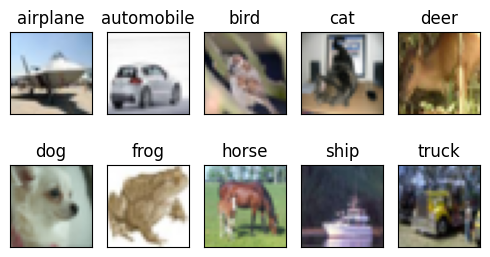

In [4]:
WIDTH_SIZE = 5
HEIGHT_SIZE = 3

num_classes = len(np.unique(y_train))
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

fig = plt.figure(figsize=(WIDTH_SIZE, HEIGHT_SIZE))
for i in range(num_classes):
    ax = plt.subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(y_train[:]==i)[0]
    features_idx = X_train[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    img = features_idx[img_num,::]
    ax.set_title(class_names[i])
    plt.imshow(img)

plt.tight_layout()

In [5]:
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [6]:
if tf.keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 3, 32, 32)
    X_test = X_test.reshape(X_test.shape[0], 3, 32, 32)
    input_shape = (3, 32, 32)
else:
    X_train = X_train.reshape(X_train.shape[0], 32, 32, 3)
    X_test = X_test.reshape(X_test.shape[0], 32, 32, 3)
    input_shape = (32, 32, 3)

# convert class vectors to binary class matrices
Y_train = tf.keras.utils.to_categorical(y_train, num_classes)
Y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# the generator is using tanh activation, for which we need to preprocess
# the image data into the range between -1 and 1.

X_train = np.float32(X_train)
X_train = (X_train / 255 - 0.5) * 2
X_train = np.clip(X_train, -1, 1)

X_test = np.float32(X_test)
X_test = (X_test / 255 - 0.5) * 2
X_test = np.clip(X_test, -1, 1)

print('X_train reshape:', X_train.shape)
print('X_test reshape:', X_test.shape)

X_train reshape: (50000, 32, 32, 3)
X_test reshape: (10000, 32, 32, 3)


In [7]:
# latent space dimension
latent_dim = 100

# Generator network
generator = tf.keras.models.Sequential()

generator.add(
    tf.keras.layers.Dense(
        2 * 2 * 512, use_bias=False, input_shape=(latent_dim,)
    )
)
generator.add(tf.keras.layers.BatchNormalization())
generator.add(tf.keras.layers.LeakyReLU())
generator.add(tf.keras.layers.Reshape((2, 2, 512)))

generator.add(
    tf.keras.layers.Conv2DTranspose(
        256, kernel_size=5, strides=2, padding="same", use_bias=False
    )
)
generator.add(tf.keras.layers.BatchNormalization())
generator.add(tf.keras.layers.LeakyReLU())

generator.add(
    tf.keras.layers.Conv2DTranspose(
        128, kernel_size=5, strides=2, padding="same", use_bias=False
    )
)
generator.add(tf.keras.layers.BatchNormalization())
generator.add(tf.keras.layers.LeakyReLU())

generator.add(
    tf.keras.layers.Conv2DTranspose(
        64, kernel_size=5, strides=2, padding="same", use_bias=False
    )
)
generator.add(tf.keras.layers.BatchNormalization())
generator.add(tf.keras.layers.LeakyReLU())

generator.add(
    tf.keras.layers.Conv2DTranspose(
        3,
        kernel_size=5,
        strides=2,
        padding="same",
        use_bias=False,
        activation="tanh",
    )
)

In [8]:
generator.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2048)              204800    
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 2048)              0         
                                                                 
 reshape (Reshape)           (None, 2, 2, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 4, 4, 256)         3276800   
 anspose)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 4, 4, 256)         1

In [9]:
# imagem shape 32x32x3
img_shape = X_train[0].shape

# Discriminator network
discriminator = tf.keras.models.Sequential()

discriminator.add(
    tf.keras.layers.Conv2D(
        64, kernel_size=5, strides=2, padding="same", input_shape=(img_shape)
    )
)
discriminator.add(tf.keras.layers.LeakyReLU())
discriminator.add(tf.keras.layers.Dropout(0.3))

discriminator.add(
    tf.keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="same")
)
discriminator.add(tf.keras.layers.LeakyReLU())
discriminator.add(tf.keras.layers.Dropout(0.3))

discriminator.add(
    tf.keras.layers.Conv2D(256, kernel_size=5, strides=2, padding="same")
)
discriminator.add(tf.keras.layers.LeakyReLU())
discriminator.add(tf.keras.layers.Dropout(0.3))

discriminator.add(
    tf.keras.layers.Conv2D(512, kernel_size=5, strides=2, padding="same")
)
discriminator.add(tf.keras.layers.LeakyReLU())
discriminator.add(tf.keras.layers.Dropout(0.3))

discriminator.add(tf.keras.layers.Flatten())

discriminator.add(tf.keras.layers.Dense(1, activation="sigmoid"))

In [10]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        4864      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         204928    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 128)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 256)        

In [11]:
# Create Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0003, beta_1=0.5)

# Compile the discriminator
discriminator.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["binary_accuracy"],
)


# Get all trainable variables from both discriminator and generator
all_trainable_variables = discriminator.trainable_variables + generator.trainable_variables

# Build the optimizer with all trainable variables
optimizer.build(all_trainable_variables)


In [12]:
discriminator.trainable = False

z = tf.keras.layers.Input(shape=(latent_dim,))
img = generator(z)
decision = discriminator(img)
d_g = tf.keras.models.Model(inputs=z, outputs=decision)

d_g.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["binary_accuracy"],
)

In [13]:
d_g.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 32, 32, 3)         4520384   
                                                                 
 sequential_1 (Sequential)   (None, 1)                 4308609   
                                                                 
Total params: 8828993 (33.68 MB)
Trainable params: 4515392 (17.22 MB)
Non-trainable params: 4313601 (16.46 MB)
_________________________________________________________________


epoch = 1/5, d_loss=0.333, g_loss=2.690                                                                                                     
1/1 [==============================] - 0s 440ms/step


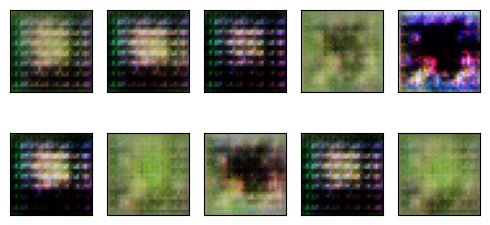

In [ ]:
epochs = 1
batch_size = 32
smooth = 0.1

real = tf.ones(shape=(batch_size, 1))
fake = tf.zeros(shape=(batch_size, 1))

d_loss = []
g_loss = []

for e in range(epochs + 1):
    for i in range(len(X_train) // batch_size):

        # Train Discriminator weights
        discriminator.trainable = True

        # Real samples
        X_batch = X_train[i * batch_size : (i + 1) * batch_size]
        d_loss_real = discriminator.train_on_batch(
            x=X_batch, y=real * (1 - smooth)
        )

        # Fake Samples
        z = tf.random.normal(shape=(batch_size, latent_dim), mean=0, stddev=1)
        X_fake = generator.predict_on_batch(z)
        d_loss_fake = discriminator.train_on_batch(x=X_fake, y=fake)

        # Discriminator loss
        d_loss_batch = 0.5 * (d_loss_real[0] + d_loss_fake[0])

        # Train Generator weights
        discriminator.trainable = False

        z = tf.random.normal(shape=(batch_size, latent_dim), mean=0, stddev=1)
        g_loss_batch = d_g.train_on_batch(x=z, y=real)

        print(
            "epoch = %d/%d, batch = %d/%d, d_loss=%.3f, g_loss=%.3f"
            % (
                e + 1,
                epochs,
                i,
                len(X_train) // batch_size,
                d_loss_batch,
                g_loss_batch[0],
            ),
            100 * " ",
            end="\r",
        )

    d_loss.append(d_loss_batch)
    g_loss.append(g_loss_batch[0])

    print(
        "epoch = %d/%d, d_loss=%.3f, g_loss=%.3f"
        % (e + 1, epochs, d_loss[-1], g_loss[-1]),
        100 * " ",
    )

    if e % 10 == 0:
        samples = 10

        z = tf.random.normal(shape=(samples, latent_dim), mean=0, stddev=1)
        x_fake = generator.predict(z)

        fig = plt.figure(figsize=(WIDTH_SIZE, HEIGHT_SIZE))
        for k in range(samples):
            plt.subplot(2, 5, k + 1, xticks=[], yticks=[])
            plt.imshow(((x_fake[k] + 1) * 127).astype(np.uint8))

        plt.tight_layout()
        plt.show()